In [1]:
import os
import glob 
import cv2
import keras
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, Concatenate, Input,  Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU

from sklearn.model_selection import train_test_split
import albumentations as A

from PIL import Image

from tqdm import tqdm


#from albumentations import Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomBrightnessContrast, HorizontalFlip, Rotate, Crop, RandomCrop

In [2]:
print(tf.__version__)

2.11.0


In [3]:
# variables
num_classes = 1
SEED = 88
random.seed(SEED)
np.random.seed(SEED)
img_size = (256, 256)
batch_size = 32
EPOCHS = 300

In [4]:
metadata = pd.read_csv("/kaggle/input/flood-area-segmentation/metadata.csv")
metadata = metadata[1:]
metadata.reset_index(drop=True, inplace=True)
image_path = "/kaggle/input/flood-area-segmentation/Image"
mask_path = "/kaggle/input/flood-area-segmentation/Mask"

In [5]:
def read_and_convert(path, key="img"):
    if key == "img":
        img = tf.keras.utils.load_img(
                            path,
                            color_mode="rgb",
                            target_size=(256, 256, 3)
                            )

        img = tf.keras.utils.img_to_array(img, dtype=np.uint8)  
    elif key == "mask":
        img = tf.keras.utils.load_img(
                            path,
                            color_mode = "grayscale",
                            target_size=(256, 256, 1)
                            )

        img = tf.keras.utils.img_to_array(img, dtype=np.uint8) 
    
    return img

In [6]:
X = np.zeros((len(metadata), 256, 256, 3), dtype=np.uint8)
Y = np.zeros((len(metadata), 256, 256, 1), dtype=np.bool_)
for i in tqdm(range(len(metadata)), total=len(metadata)):
    img = read_and_convert(os.path.join(image_path, metadata["Image"].loc[i]), key="img")
    X[i] = img
    mask = read_and_convert(os.path.join(mask_path, metadata["Mask"].loc[i]), "mask")
    Y[i] = mask
                           

100%|██████████| 289/289 [00:16<00:00, 17.98it/s]


In [7]:
print(X.shape)
print(Y.shape)

(289, 256, 256, 3)
(289, 256, 256, 1)


In [8]:
metadata.head()

,Image,Mask
0,1.jpg,1.png
1,2.jpg,2.png
2,3.jpg,3.png
3,4.jpg,4.png
4,5.jpg,5.png


In [9]:
metadata.shape

(289, 2)

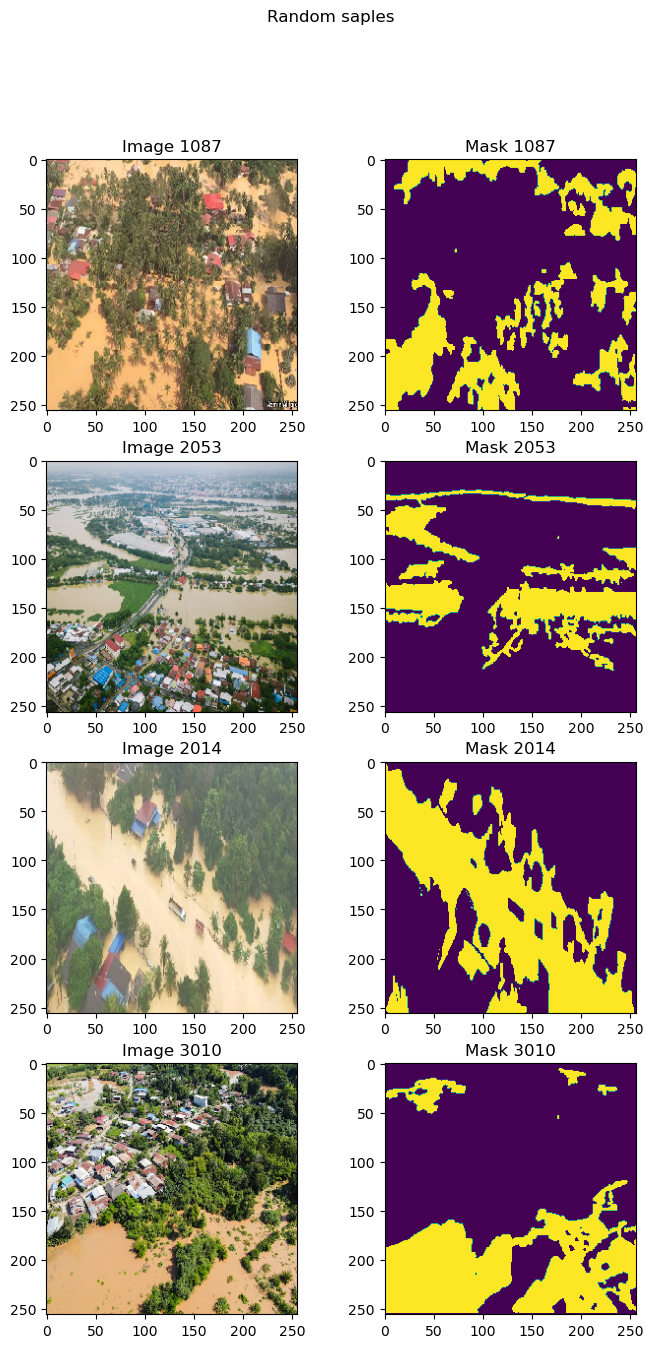

In [10]:



def transform(img, mask):
    transforms = A.Compose([
                        A.Rotate(),
                        A.RandomBrightness(limit=0.1),
                        A.HorizontalFlip(),
                        A.Crop(always_apply=False, p=1.0, x_min=50, y_min=50, x_max=200, y_max=200),
                        ])
    return transforms(image=img, mask=mask)


def visualize(X ,Y, metadata, n=4):
    rand_numbers = np.random.randint(0, X.shape[0], n)
    fig, ax = plt.subplots(n, 2, figsize = (8,15))
    fig.suptitle('Random saples')
    
    
    for i in range(n):
        img = X[i]
        #print(img.shape, "img", (np.max(img)))
        mask = Y[i]

        #print(mask.shape, "mask", (np.max(mask)))
        # if you 
        #transformed = transform(img, mask)
        #img = transformed['image']
        #mask = transformed['mask']

        ax[i, 0].imshow(img)
        ax[i, 0].set_title(f'Image {metadata["Image"].iloc[rand_numbers[i]].split(".")[0]}')
        #ax[i, 0].set_axis_off() 
        
        ax[i, 1].imshow(mask)
        ax[i, 1].set_title(f'Mask {metadata["Mask"].iloc[rand_numbers[i]].split(".")[0]}')
        #ax[i, 1].set_axis_off()

        
visualize(X, Y, metadata )

In [11]:
class floodareaDatasetGen(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    def __init__(self, X, Y, batch_size, img_size, train=False):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.img_size = img_size
        self.train = train


    def __len__(self):
        return self.X.shape[0] // self.batch_size

    def __getitem__(self, idx):
        """
        Method that returns a tuple (input, target) corresponding to batch idx.
        It retrieves a batch of the DataFrame by slicing it from i to i + batch_size.
        It then reads and converts the images and labels using the _read_and_convert method,
        appends them to X and y, respectively, and returns them as Numpy arrays.
        """
        i = idx * self.batch_size
        batch_X = self.X[i : i + self.batch_size].astype(np.float32)
        batch_Y = self.Y[i : i + self.batch_size].astype(np.float32)
        
        if self.train == False:
            return batch_X / 255. , batch_Y

        for _ in range(batch_X.shape[0]):
            transformed = self._transform(batch_X[_], batch_Y[_])
            img = transformed['image']
            mask = transformed['mask']
        batch_X /= 255.

 
        return batch_X, batch_Y
            
    
    def _transform(self, img, mask):
        h, w, _ = img.shape
        transforms = A.Compose([
            A.Rotate(limit=45, interpolation=0, border_mode=3),
            #A.RandomCrop(always_apply=False, p=.3, height=int(h - h*0.1), width=int(w - w*0.1)),
            A.RandomSizedCrop(always_apply=False, p=1.0, min_max_height=(int(h - h*0.2), int(w - w*0.2)), 
                            height=h, width=w, w2h_ratio=1.0, interpolation=0),

            #A.Resize(always_apply=True, p=1.0, height=h, width=w, interpolation=0),
            A.HorizontalFlip(always_apply=False, p=.3),
            A.VerticalFlip(always_apply=False, p=.3),
            
        ])
        
        return transforms(image=img, mask=mask)

In [12]:
X_train, _X, y_train, _y = train_test_split(X, Y, test_size=0.3, random_state=SEED)
X_test, X_valid, y_test, y_valid = train_test_split(_X, _y, test_size=0.5, random_state=SEED)



In [13]:
train = floodareaDatasetGen(X_train, y_train, batch_size, img_size, train=True)
test = floodareaDatasetGen(X_test, y_test, batch_size, img_size, train=False)
valid = floodareaDatasetGen(X_valid, y_valid, batch_size, img_size, train=False)

In [14]:
def downsample_block(x, filters, kernel_size, activation='relu', kernel_initializer='he_normal', padding='same', dropout=0):
    x = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding)(x)
    x = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding)(x)
    skip_connection = x
    if dropout > 0:
        x = Dropout(dropout)(x)
        
    x = MaxPooling2D((2,2))(x)
    
    return x, skip_connection
#u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
def upsampling_block(x, skip, filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same'):
    up = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    concat = Concatenate()([up, skip])
    conv = Conv2D(filters, kernel_size, padding=padding, activation="relu")(concat)
    conv = Conv2D(filters, kernel_size, padding=padding, activation="relu")(conv)
    
    return conv

def bottleneck(x, filters, kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same', dropout=0):
    x = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding)(x)
    x = Conv2D(filters, kernel_size, activation=activation, kernel_initializer=kernel_initializer, padding=padding)(x)
    if dropout > 0:
        x = Dropout(dropout)(x)
    return x


def Unet(num_classes, image_shape, filters, kernel_size):
    inputs = Input(image_shape)
                
    x, skip1 = downsample_block(inputs, filters, kernel_size)
    x, skip2 = downsample_block(x, filters*2, kernel_size)
    x, skip3 = downsample_block(x, filters*4, kernel_size)
    x, skip4 = downsample_block(x, filters*8, kernel_size, dropout=0.3)
                   
    x = bottleneck(x, filters*16, dropout=0.3)
    
    x = upsampling_block(x, skip4, filters*8)
    x = upsampling_block(x, skip3, filters*4)
    x = upsampling_block(x, skip2, filters*2)
    x = upsampling_block(x, skip1, filters)
    
    outputs =  Conv2D(num_classes, (1, 1), activation='sigmoid')(x)
    model = Model(inputs, outputs)        
    return model

In [15]:
model =  Unet(num_classes=1, image_shape=(256, 256, 3), filters=32, kernel_size=(3, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

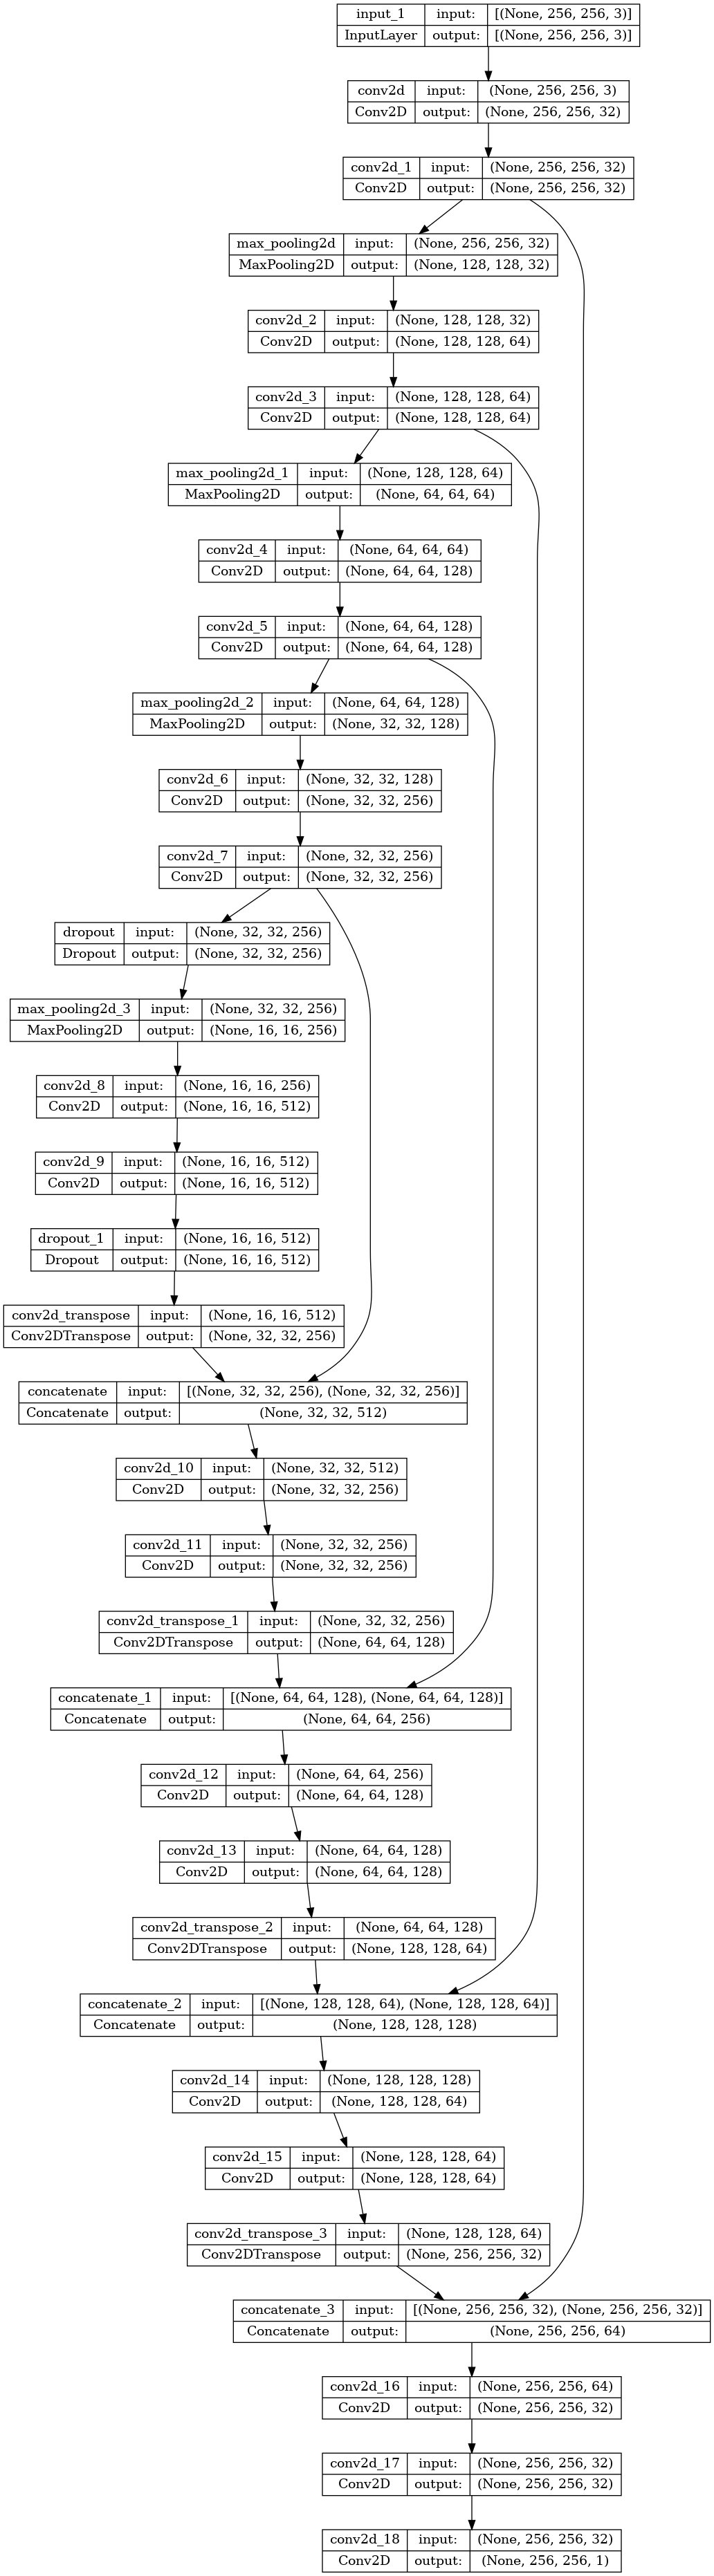

In [16]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [18]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 50,
    verbose = 1,
    mode = "min"
    )

filepath = "/kaggle/working/"

model_checkpoint = ModelCheckpoint(
    filepath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min')

history = model.fit(train,
                    validation_data=valid,
                    epochs=300,
                    verbose=1,
                    callbacks=[model_checkpoint, early_stopping]
                   )

Epoch 1/300


2023-03-25 17:07:18.280905: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


6/6 [==============================] - ETA: 0s - loss: 0.7423 - acc: 0.5950
Epoch 1: val_loss improved from inf to 0.67915, saving model to /kaggle/working/
6/6 [==============================] - 24s 1s/step - loss: 0.7423 - acc: 0.5950 - val_loss: 0.6792 - val_acc: 0.5617
Epoch 2/300
6/6 [==============================] - ETA: 0s - loss: 0.6898 - acc: 0.5035
Epoch 2: val_loss improved from 0.67915 to 0.67879, saving model to /kaggle/working/
6/6 [==============================] - 7s 1s/step - loss: 0.6898 - acc: 0.5035 - val_loss: 0.6788 - val_acc: 0.6818
Epoch 3/300
6/6 [==============================] - ETA: 0s - loss: 0.6760 - acc: 0.7386
Epoch 3: val_loss improved from 0.67879 to 0.66081, saving model to /kaggle/working/
6/6 [==============================] - 6s 1s/step - loss: 0.6760 - acc: 0.7386 - val_loss: 0.6608 - val_acc: 0.7992
Epoch 4/300
6/6 [==============================] - ETA: 0s - loss: 0.6366 - acc: 0.7904
Epoch 4: val_loss improved from 0.66081 to 0.58396, saving m

In [19]:
model = tf.keras.models.load_model('/kaggle/working/')

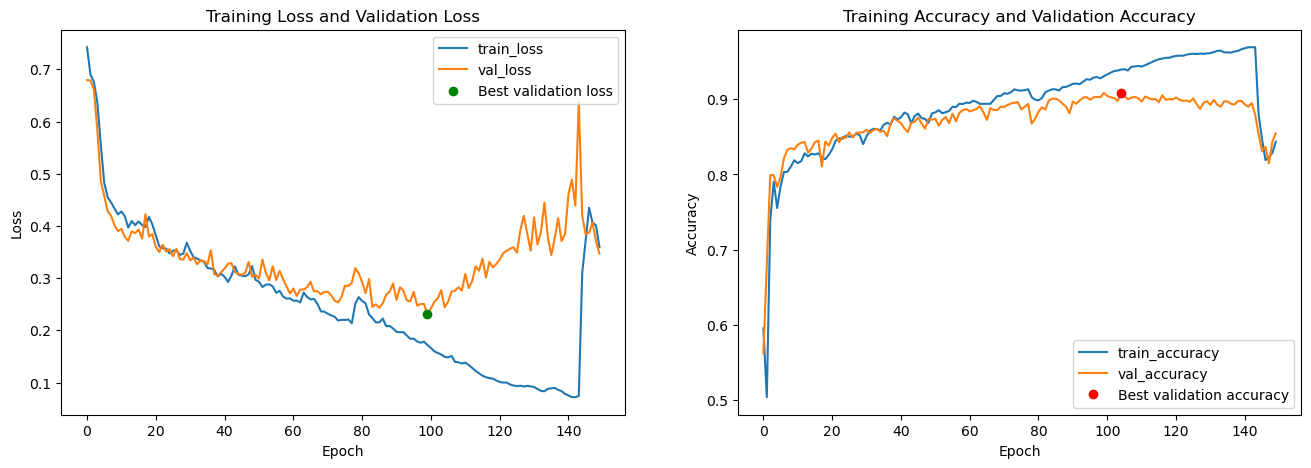

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].plot(history.history['loss'], label='train_loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].legend()
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss and Validation Loss')

axs[1].plot(history.history['acc'], label='train_accuracy')
axs[1].plot(history.history['val_acc'], label='val_accuracy')
axs[1].legend()
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy and Validation Accuracy')

# Find the index of the smallest validation loss
best_val_loss_idx = np.argmin(history.history['val_loss'])
best_val_loss = history.history['val_loss'][best_val_loss_idx]

# Plot a green dot for the smallest validation loss
axs[0].plot(best_val_loss_idx, best_val_loss, 'go', label='Best validation loss')

# Find the index of the highest validation accuracy
best_val_acc_idx = np.argmax(history.history['val_acc'])
best_val_acc = history.history['val_acc'][best_val_acc_idx]

# Plot a red dot for the best validation accuracy
axs[1].plot(best_val_acc_idx, best_val_acc, 'ro', label='Best validation accuracy')

# Update legend to include both dots
axs[0].legend(loc='upper right')
axs[1].legend(loc='lower right')

plt.show()

In [21]:
test_loss, test_acc = model.evaluate(test)

print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_acc:.4f}')

1/1 [==============================] - 1s 586ms/step - loss: 0.2665 - acc: 0.9003
Test loss: 0.2665
Test accuracy: 0.9003


In [22]:
X_test, y_test = test[0]

(32, 256, 256, 3)
5
1/1 [==============================] - 1s 551ms/step
12
1/1 [==============================] - 0s 22ms/step
26
1/1 [==============================] - 0s 20ms/step
16
1/1 [==============================] - 0s 20ms/step
2
1/1 [==============================] - 0s 20ms/step


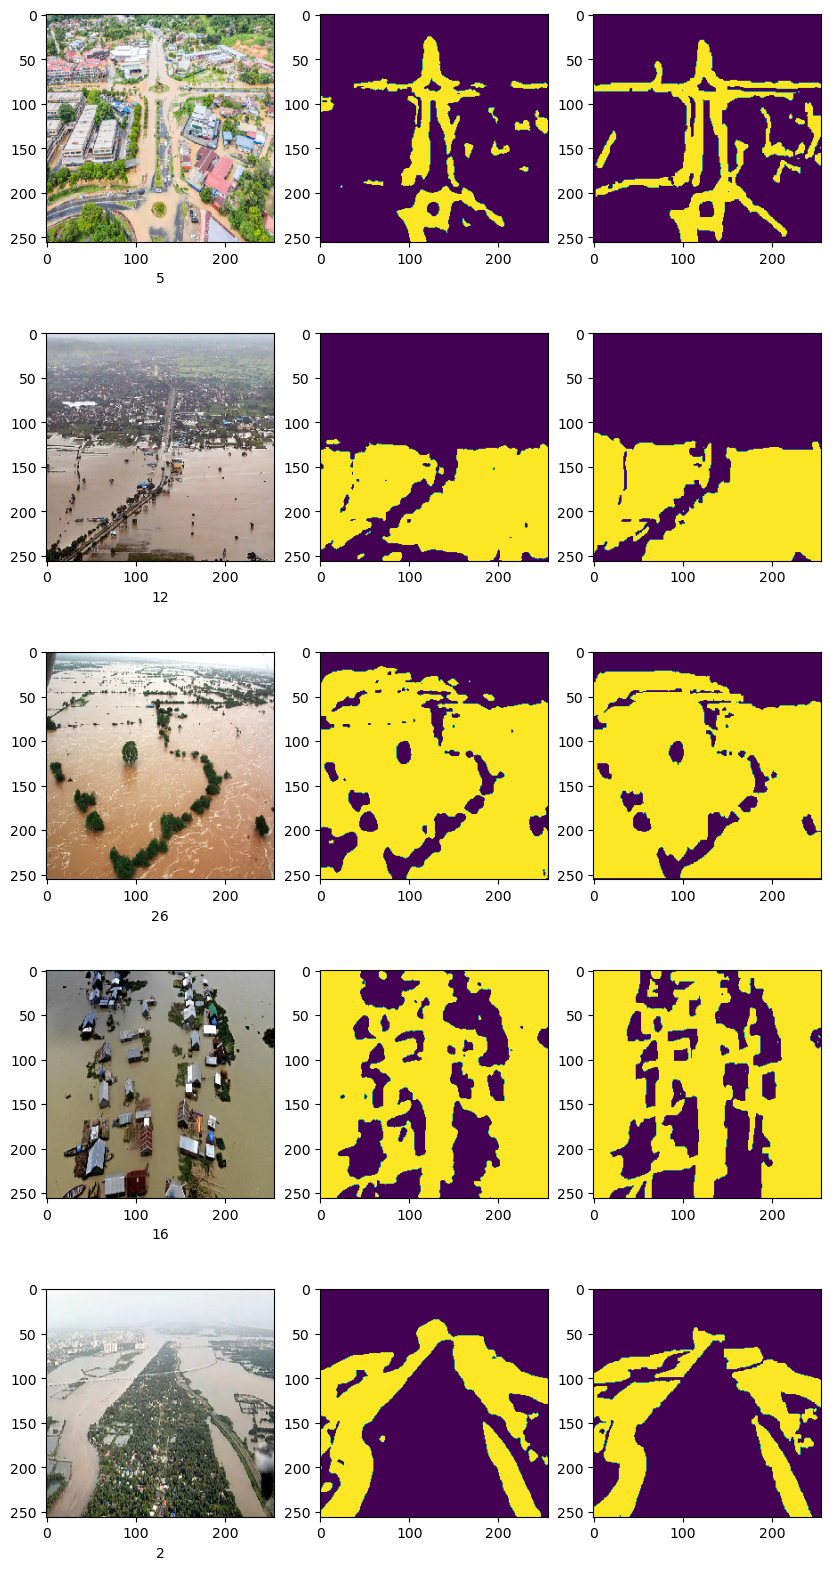

In [23]:
print(X_test.shape) 

#img = read_and_convert("/kaggle/input/fire-tests/maxresdefault.jpg")

#p = 0.8 
def visualize_predict(number, X, y):
    numbers = np.random.randint(0, X_test.shape[0], number)
    
    fig, ax = plt.subplots(number, 3, figsize = (10, number*4))
    
    for i, n in enumerate(numbers):
        print(n)

        img = X[n]
        mask = y[n]
        pred = model.predict(np.expand_dims(img, axis=0))
        ax[i, 0].imshow(img)
        ax[i, 1].imshow(np.squeeze(pred, axis=0) > 0.6 ) 
        ax[i, 2].imshow(mask)
        ax[i, 0].set_xlabel(n)



visualize_predict(5, X_test, y_test)